# Capítulo 12: Redes Antagónicas Generativas (GAN)

In [7]:
from keras.datasets import mnist

In [8]:
mnist_data = mnist.load_data()
(X_train, y_train), (X_test, y_test) = mnist_data

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Reshape, LeakyReLU
from keras.optimizers import Adam

In [10]:
def generador_gan():
    generador = Sequential()
    generador.add(Dense(128, input_dim=100))
    generador.add(LeakyReLU(alpha=0.01))
    generador.add(Dense(28*28*1, activation='tanh'))
    generador.add(Reshape((28,28,1)))
    return generador

In [11]:
model_generador = generador_gan()
print(model_generador.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               12928     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 784)               101136    
                                                                 
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
Total params: 114064 (445.56 KB)
Trainable params: 114064 (445.56 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [12]:
def discriminador_gan():
    discriminador = Sequential()
    discriminador.add(Flatten(input_shape = (28,28,1)))
    discriminador.add(Dense(128))
    discriminador.add(LeakyReLU(alpha=0.01))
    discriminador.add(Dense(1, activation='sigmoid'))
    return discriminador

In [13]:
model_discriminador = discriminador_gan()
print(model_discriminador.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               100480    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 100609 (393.00 KB)
Trainable params: 100609 (393.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [14]:
#combinando el generador y discriminador para formar el modelo GAN
def gan_combinado(generador, discriminador):
    modelo_combinado = Sequential()
    modelo_combinado.add(generador)
    modelo_combinado.add(discriminador)
    return modelo_combinado

In [15]:
model_discriminador.compile(loss="binary_crossentropy", optimizer=Adam(), metrics=['accuracy'])
model_discriminador.trainable = False

modelo_gan_combinado = gan_combinado(model_generador, model_discriminador)
modelo_gan_combinado.compile(loss="binary_crossentropy", optimizer=Adam())
print(modelo_gan_combinado.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 28, 28, 1)         114064    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 100609    
                                                                 
Total params: 214673 (838.57 KB)
Trainable params: 114064 (445.56 KB)
Non-trainable params: 100609 (393.00 KB)
_________________________________________________________________
None


In [16]:
import numpy as  np

def entrenamiento_gan():

    n_iteraciones = 10000
    tam_lote = 128
    salto = 1000

    mnist_data = mnist.load_data()
    (X_train, y_train), (X_test, y_test) = mnist_data

    X_train = X_train/127.5-1

    X_train = np.expand_dims(X_train, axis=3)

    etiquetas_imgs_reales = np.ones((tam_lote,1))
    etiquetas_imgs_falsas = np.zeros((tam_lote,1))

    for num_iter in range(n_iteraciones):

        num_aleatorios = np.random.randint(0, X_train.shape[0], tam_lote)
        images_reales = X_train[num_aleatorios]

        #entrenamos al discriminador con imágenes reales y obtenga el valor de pérdida y precisión
        eval_discriminador_imgs_reales = model_discriminador.train_on_batch(images_reales, etiquetas_imgs_reales)

        #Creamos un vector de 100 elementos de ruido aleatorio
        vector_ruido_aleatorio = np.random.normal(0,1,(tam_lote,100))
        # obtenemos un lote de imágenes falsas a partir del vector de ruido aleatorio
        imgs_falsas = model_generador.predict(vector_ruido_aleatorio)

        #entrenamos al discriminador con imágenes falsas y obtenga el valor de pérdida y precisión
        eval_discriminador_imgs_falsas = model_discriminador.train_on_batch(imgs_falsas, etiquetas_imgs_falsas)

        #encuentre el valor promedio de pérdida y precisión dividiendo el total de valores reales y falsos por 2
        perdida_discriminador, exactitud_discriminador = 0.5 * np.add(eval_discriminador_imgs_reales, eval_discriminador_imgs_falsas)

        #Creamos un vector de 100 elementos de ruido aleatorio
        vector_ruido_aleatorio2 = np.random.normal(0,1,(tam_lote,100))

        #entrenamos el gan combinado con vectores de ruido aleatorios y etiquetas de imágenes reales
        #Dado que mantenemos el discriminador constante, necesitamos que la GAN piense que todas las imágenes que genera
        # ya están clasificadas por el discriminador como reales.
        perdida_generador = modelo_gan_combinado.train_on_batch(vector_ruido_aleatorio2, etiquetas_imgs_reales)

        print("Iteration: %d" %(num_iter+1))

        if (num_iter+1)%salto == 0:

            print("Iteración: %d - Exactitud del discriminador: %.2f" %(num_iter+1 , exactitud_discriminador*100))

            #serializar la estructura del modelo del generador
            model_json = model_generador.to_json()
            #guardamos el json serializado
            with open("modelo_gan_generado.json","w") as json_file:
                json_file.write(model_json)

            #serializamos los pesos del modelo del generador como archivo hdf5
            model_generador.save_weights("modelo_gan_generado.weights.h5")

In [18]:
def dibujar_muestra(modelo):
    ruido = np.random.normal(0,1,(4*4,100))
    imgs_generadas = modelo.predict(ruido)
    imgs_generadas = 0.5*imgs_generadas+0.5
    figure, axes = plt.subplots(4,4, figsize=(4,4), sharey=True, sharex=True)

    counter = 0
    for i in range(4):
        for j in range(4):
            axes[i, j].imshow(imgs_generadas[counter, :,:,0], cmap='gray')
            axes[i, j].axis('off')
            counter += 1
    plt.show()

In [19]:
entrenamiento_gan()

Se truncaron las últimas líneas 5000 del resultado de transmisión.
Iteration: 7502
4/4 [==============================] - 0s 2ms/step
Iteration: 7503
4/4 [==============================] - 0s 2ms/step
Iteration: 7504
4/4 [==============================] - 0s 2ms/step
Iteration: 7505
4/4 [==============================] - 0s 2ms/step
Iteration: 7506
4/4 [==============================] - 0s 2ms/step
Iteration: 7507
4/4 [==============================] - 0s 2ms/step
Iteration: 7508
4/4 [==============================] - 0s 2ms/step
Iteration: 7509
4/4 [==============================] - 0s 2ms/step
Iteration: 7510
4/4 [==============================] - 0s 2ms/step
Iteration: 7511
4/4 [==============================] - 0s 2ms/step
Iteration: 7512
4/4 [==============================] - 0s 2ms/step
Iteration: 7513
4/4 [==============================] - 0s 2ms/step
Iteration: 7514
4/4 [==============================] - 0s 2ms/step
Iteration: 7515
4/4 [==============================] - 0s 2ms/

1/1 [==============================] - 0s 64ms/step


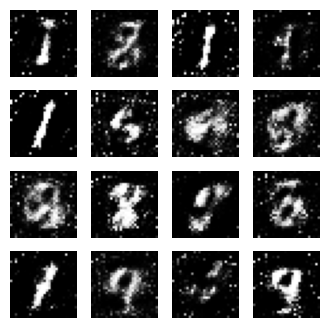

In [20]:
from keras.models import model_from_json
import numpy as  np
import matplotlib.pyplot as plt

#cargamos el archivo json
archivo_modelo_json = open("modelo_gan_generado.json","r")
modelo_json = archivo_modelo_json.read()
archivo_modelo_json.close()

#creamos el modelo json
modelo_gan = model_from_json(modelo_json)

#cargamos los pesos del modelo
modelo_gan.load_weights("modelo_gan_generado.weights.h5")

#generar imágenes aleatorias generadas por nuestro modelo
dibujar_muestra(modelo_gan)
